## Study of type event recognition for the PETALO experiment using ML

### Imports

In [1]:
import numpy  as np
import pandas as pd
import random

from random import randrange, uniform

import matplotlib.pyplot as plt

In [2]:
#in terminal set the course conda env: conda activate machine-learning-course
from tensorflow.keras               import layers
from tensorflow.keras               import regularizers
from tensorflow.keras.utils         import to_categorical
from tensorflow.keras.models        import Sequential
from tensorflow.keras.layers        import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks     import ModelCheckpoint, EarlyStopping

### Loading data:

Code to select events and plotting utils in https://github.com/carmenromo/Analysis/tree/master/machine_learning_course

In [3]:
phot_list, compt_list = [], []
data_file  = '/Users/carmenromoluque/machine-learning-course/full_body_4cmdepth_all_images_correct_compton.npz'
data       = np.load(data_file, allow_pickle=True)
for im in data['phot_images']:
    if len(im)==0:
        continue
    phot_list .append(im.reshape(400))
for im in data['compt_images']:
    if len(im)==0:
        continue
    compt_list.append(im.reshape(400))
compt_images = np.array(compt_list)
phot_images  = np.array(phot_list)

In [4]:
phot_images.shape

(19932, 400)

#### Create the noisy events
I am going to use gaussian distributions

In [5]:
def multivariate_gaussian(pos, mu, sigma):
    n         = mu.shape[0]
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    N         = np.sqrt((2*np.pi)**n * sigma_det)
    fac       = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
    return np.exp(-fac/2)/N

In [6]:
#noise_images = 20 *np.random.rand(5000, 400) #20 has been chosen randomly
n_bins  = 20
n_dist  = 10000
gauss2d = []
for i in range(n_dist):
    x_rand = np.linspace(-randrange(1, 10), randrange(1, 10), n_bins)
    y_rand = np.linspace(-randrange(1, 10), randrange(1, 10), n_bins)
    x_rand, y_rand = np.meshgrid(x_rand, y_rand)
    # Mean vector and covariance matrix
    mu = np.array([0., randrange(1, 3)])
    sigma = np.array([[uniform(0.5, 2), -0.5], [-0.5, uniform(0.5, 2)]])
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(x_rand.shape + (2,))
    pos[:, :, 0] = x_rand
    pos[:, :, 1] = y_rand
    # The distribution on the variables X, Y packed into pos.
    gauss2d = np.append(gauss2d, multivariate_gaussian(pos, mu, sigma))

gauss2d      = gauss2d.reshape(n_dist, 400)
noise_images = gauss2d

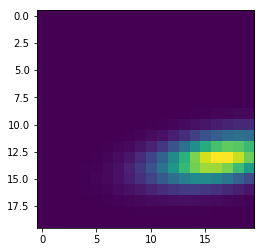

In [7]:
plt.imshow(gauss2d[1].reshape(20, 20));

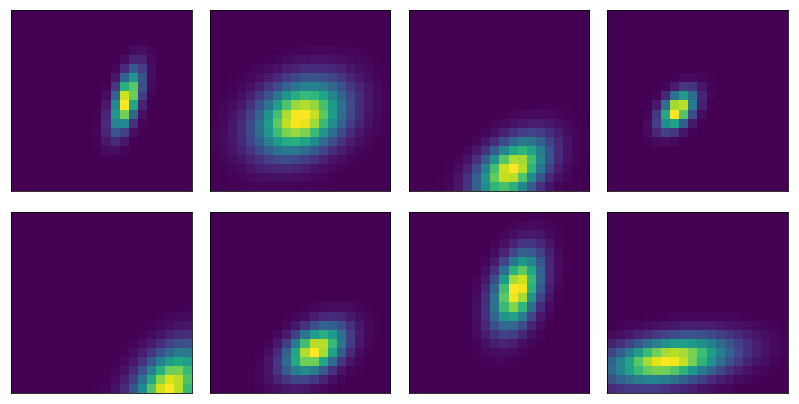

In [8]:
gauss2d_image = gauss2d.reshape(len(gauss2d),20,20)
fig = plt.figure(figsize=(12, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(gauss2d_image[randrange(1, len(gauss2d))], interpolation='nearest')

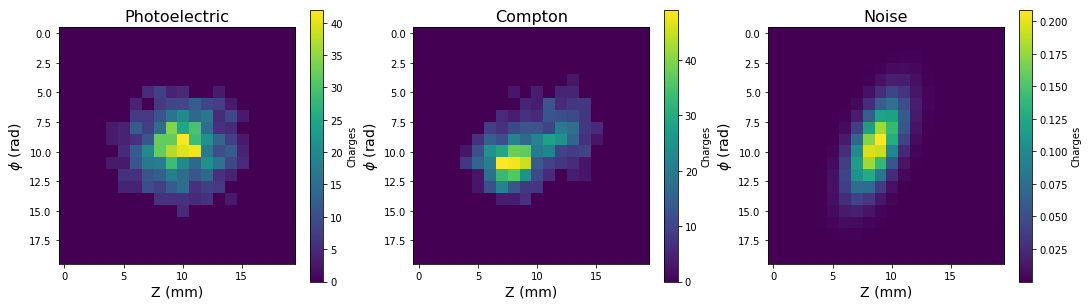

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,5))
fig1 = ax1.imshow( phot_images[4].reshape(20,20))
fig2 = ax2.imshow(compt_images[9].reshape(20,20))
fig3 = ax3.imshow(noise_images[5].reshape(20,20))
ax1.set_xlabel('Z (mm)',       size=14)
ax1.set_ylabel('$\phi$ (rad)', size=14)
ax1.set_title('Photoelectric', size=16)
ax2.set_xlabel('Z (mm)',       size=14)
ax2.set_ylabel('$\phi$ (rad)', size=14)
ax2.set_title('Compton',       size=16)
ax3.set_xlabel('Z (mm)',       size=14)
ax3.set_ylabel('$\phi$ (rad)', size=14)
ax3.set_title('Noise',         size=16)
fig.colorbar(fig1, ax=ax1, label='Charges')
fig.colorbar(fig2, ax=ax2, label='Charges')
fig.colorbar(fig3, ax=ax3, label='Charges')
plt.show()

In the previous plot I have chosen ideal images of photoelectric and compton (phot more compact and compton more sparse), because I found that the pattern in the sipms is pretty similar between these two kinds of events, that's why I would be so happy if the CNN manages to distinguish them successfully.

#### Create the labels:
- compton:       0
- photoelectric: 1
- noise:         2

In [10]:
compt_labels =   np.zeros(len(compt_images))
phot_labels  =   np.ones (len( phot_images))
noise_labels = 2*np.ones (len(noise_images))

### Normalization:

Data can be normalized either using the maximum charge corresponding to every event type or either using the maximum absolute charge value. I think the most correct is the second option because maybe we are missing some information in the number of charges between photoelectric and compton events.

However I find better results in the previous one...

In [11]:
#max_charges = [np.max( phot_images), np.max(compt_images), np.max(noise_images)]
#abs_max = max(max_charges)
#abs_max

#norm_phot_images  =  phot_images/abs_max
#norm_compt_images = compt_images/abs_max
#norm_noise_images = noise_images/abs_max

#norm_phot_images  =  phot_images/np.max( phot_images)
#norm_compt_images = compt_images/np.max(compt_images)
#norm_noise_images = noise_images/np.max(noise_images)

In [12]:
norm_phot_images  = np.array([i/np.max(i) for i in  phot_images])
norm_compt_images = np.array([i/np.max(i) for i in compt_images])
norm_noise_images = np.array([i/np.max(i) for i in noise_images])

## Inputs for the CNN:

In [14]:
y = np.concatenate((compt_labels,      phot_labels,      noise_labels))
x = np.concatenate((norm_compt_images, norm_phot_images, norm_noise_images))
print(y.shape)
print(x.shape)
print(y)

(54016,)
(54016, 400)
[0. 0. 0. ... 2. 2. 2.]


We want to mix the images so that they are not in order (but labels in the same way too):

In [15]:
c = list(zip(x, y))
np.random.shuffle(c)
x, y = zip(*c)
y = np.array(y)
x = np.array(x).astype('float32') 

Split data in trining, validation and testing:

In [16]:
#######
train_split = 42000
#######
test_split  = 6000
#######

y_train = y[                 :train_split]
x_train = x[                 :train_split]
y_val   = y[train_split      :len(y)-test_split]
x_val   = x[train_split      :len(x)-test_split]
y_test  = y[len(y)-test_split:                 ]
x_test  = x[len(x)-test_split:                 ]

In [17]:
print(x_test .shape, y_test .shape)
print(x_train.shape, y_train.shape)
print(x_val  .shape, y_val  .shape)

(6000, 400) (6000,)
(42000, 400) (42000,)
(6016, 400) (6016,)


In [18]:
myset     = set(y_train)
mysettest = set(y_test)
print(myset)
print(mysettest)
print(y)

{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}
[0. 1. 1. ... 1. 2. 0.]


In [19]:
y_train_hot = to_categorical(y_train)
y_val_hot   = to_categorical(y_val)
y_test_hot  = to_categorical(y_test)

print(y_train_hot.shape)
print(y_val_hot  .shape)
print(y_test_hot .shape)

(42000, 3)
(6016, 3)
(6000, 3)


42000 train samples
6016 validation samples


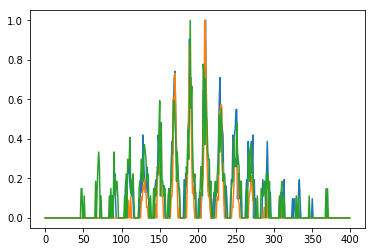

In [20]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
plt.plot(x_train[0])
plt.plot(x_train[1])
plt.plot(x_test[0])
plt.show()

Reshape data for CNN:

In [21]:
x_train_cnn = x_train.reshape(-1, 20, 20, 1)
x_test_cnn  = x_test .reshape(-1, 20, 20, 1)
x_val_cnn   = x_val  .reshape(-1, 20, 20, 1)
x_train_cnn.shape

(42000, 20, 20, 1)

In [22]:
layer = layers.Dense(
    units=64,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)

# a fairly small network for speed
cnnmodel = Sequential()
#cnnmodel.add(Conv2D(128, (4, 4), activation='relu', input_shape=(20, 20, 1)))
cnnmodel.add(Conv2D(64, (3, 3), activation='relu', input_shape=(20, 20, 1))) #2D convolution layer
cnnmodel.add(MaxPooling2D((2, 2))) #Max pooling operation for 2D spatial data.
cnnmodel.add(layer)
cnnmodel.add(Dropout(0.4, input_shape=(20,20,1)))
cnnmodel.add(Conv2D(256, (4, 4), activation='relu'))
#cnnmodel.add(Conv2D(128, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1, input_shape=(20,20,1)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(3, activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
                optimizer='adam', #RMSprop(),
                metrics=['accuracy'])

cnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 64)          0         
_________________________________________________________________
dense (Dense)                (None, 9, 9, 64)          4160      
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 256)         262400    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 256)         0

In [23]:
batch_size = 50
epochs     = 20

## To prevent it from memorizing the learning samples when the number of epochs is high

dir_path        = '/Users/carmenromoluque/machine-learning-course/'
best_model_name = dir_path + f'CNN_regression_R_{epochs}_{batch_size}.h5'
model_check     = ModelCheckpoint(best_model_name, monitor='val_sigma', verbose=1, save_best_only=True, 
                                  save_weights_only=False, mode='min', save_freq=1)
early_stop      = EarlyStopping(monitor='val_loss', min_delta=0, patience=900, 
                                verbose=1, mode='auto', baseline=None)


history = cnnmodel.fit(x_train_cnn, y_train_hot,
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val_cnn, y_val_hot),
                       callbacks=[model_check, early_stop])

Train on 42000 samples, validate on 6016 samples
Epoch 1/20
 2350/42000 [>.............................] - ETA: 1:35 - loss: 0.7852 - accuracy: 0.6209WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4750/42000 [==>...........................] - ETA: 1:19 - loss: 0.6902 - accuracy: 0.6571WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7150/42000 [====>.........................] - ETA: 1:18 - loss: 0.6402 - accuracy: 0.6780WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9550/42000 [=====>........................] - ETA: 1:12 - loss: 0.6060 - accuracy: 0.6923WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11950/42000 [=======>......................] - ETA: 1:04 - loss: 0.5841 - accuracy: 0.7009WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14350/42000 [=========>....................] - ETA: 57s - loss: 0.5685 - accuracy: 0.7052WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16750/42000 [==========>...................] - ETA: 51s - loss: 0.5548 - accuracy: 0.7102WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19150/42000 [============>.................] - ETA: 46s - loss: 0.5413 - accuracy: 0.7169WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21550/42000 [==============>...............] - ETA: 42s - loss: 0.5334 - accuracy: 0.7199WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23950/42000 [================>.............] - ETA: 36s - loss: 0.5257 - accuracy: 0.7214WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26350/42000 [=================>............] - ETA: 31s - loss: 0.5195 - accuracy: 0.7237WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28750/42000 [===================>..........] - ETA: 26s - loss: 0.5137 - accuracy: 0.7264WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31150/42000 [=====================>........] - ETA: 21s - loss: 0.5098 - accuracy: 0.7279WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33550/42000 [======================>.......] - ETA: 16s - loss: 0.5057 - accuracy: 0.7292WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35950/42000 [========================>.....] - ETA: 11s - loss: 0.5017 - accuracy: 0.7314WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38400/42000 [==========================>...] - ETA: 6s - loss: 0.4979 - accuracy: 0.7332WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40850/42000 [============================>.] - ETA: 2s - loss: 0.4961 - accuracy: 0.7336WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 81s 2ms/sample - loss: 0.4947 - accuracy: 0.7343 - val_loss: 0.4271 - val_accuracy: 0.7675
Epoch 2/20
 1250/42000 [..............................] - ETA: 1:02 - loss: 0.4315 - accuracy: 0.7536WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3650/42000 [=>............................] - ETA: 1:13 - loss: 0.4258 - accuracy: 0.7688WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6050/42000 [===>..........................] - ETA: 1:07 - loss: 0.4287 - accuracy: 0.7661WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8450/42000 [=====>........................] - ETA: 59s - loss: 0.4273 - accuracy: 0.7647WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10850/42000 [======>.......................] - ETA: 53s - loss: 0.4294 - accuracy: 0.7641WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13250/42000 [========>.....................] - ETA: 48s - loss: 0.4309 - accuracy: 0.7643WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15650/42000 [==========>...................] - ETA: 43s - loss: 0.4310 - accuracy: 0.7631WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18050/42000 [===========>..................] - ETA: 39s - loss: 0.4342 - accuracy: 0.7611WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20450/42000 [=============>................] - ETA: 35s - loss: 0.4337 - accuracy: 0.7611WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22850/42000 [===============>..............] - ETA: 31s - loss: 0.4335 - accuracy: 0.7610WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25250/42000 [=================>............] - ETA: 28s - loss: 0.4332 - accuracy: 0.7608WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27650/42000 [==================>...........] - ETA: 24s - loss: 0.4312 - accuracy: 0.7625WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30050/42000 [====================>.........] - ETA: 20s - loss: 0.4310 - accuracy: 0.7630WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32450/42000 [======================>.......] - ETA: 16s - loss: 0.4312 - accuracy: 0.7624WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34850/42000 [=======================>......] - ETA: 12s - loss: 0.4312 - accuracy: 0.7625WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37300/42000 [=========================>....] - ETA: 7s - loss: 0.4319 - accuracy: 0.7618WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39750/42000 [===========================>..] - ETA: 3s - loss: 0.4321 - accuracy: 0.7621WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 72s 2ms/sample - loss: 0.4325 - accuracy: 0.7621 - val_loss: 0.4100 - val_accuracy: 0.7799
Epoch 3/20
  150/42000 [..............................] - ETA: 1:01 - loss: 0.4000 - accuracy: 0.8000WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2550/42000 [>.............................] - ETA: 1:01 - loss: 0.4378 - accuracy: 0.7671WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4950/42000 [==>...........................] - ETA: 57s - loss: 0.4464 - accuracy: 0.7584WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7350/42000 [====>.........................] - ETA: 53s - loss: 0.4412 - accuracy: 0.7585WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9750/42000 [=====>........................] - ETA: 51s - loss: 0.4343 - accuracy: 0.7616WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12150/42000 [=======>......................] - ETA: 47s - loss: 0.4354 - accuracy: 0.7597WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14550/42000 [=========>....................] - ETA: 44s - loss: 0.4304 - accuracy: 0.7635WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16950/42000 [===========>..................] - ETA: 40s - loss: 0.4284 - accuracy: 0.7644WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19350/42000 [============>.................] - ETA: 36s - loss: 0.4267 - accuracy: 0.7659WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21750/42000 [==============>...............] - ETA: 32s - loss: 0.4265 - accuracy: 0.7652WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24150/42000 [================>.............] - ETA: 28s - loss: 0.4249 - accuracy: 0.7656WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26550/42000 [=================>............] - ETA: 24s - loss: 0.4243 - accuracy: 0.7672WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28950/42000 [===================>..........] - ETA: 20s - loss: 0.4232 - accuracy: 0.7682WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31350/42000 [=====================>........] - ETA: 17s - loss: 0.4231 - accuracy: 0.7681WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33750/42000 [=======================>......] - ETA: 13s - loss: 0.4235 - accuracy: 0.7670WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36150/42000 [========================>.....] - ETA: 9s - loss: 0.4226 - accuracy: 0.7679WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38600/42000 [==========================>...] - ETA: 5s - loss: 0.4222 - accuracy: 0.7684WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41050/42000 [============================>.] - ETA: 1s - loss: 0.4223 - accuracy: 0.7683WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 69s 2ms/sample - loss: 0.4226 - accuracy: 0.7681 - val_loss: 0.4027 - val_accuracy: 0.7749
Epoch 4/20
 1450/42000 [>.............................] - ETA: 1:00 - loss: 0.4341 - accuracy: 0.7517WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3850/42000 [=>............................] - ETA: 58s - loss: 0.4190 - accuracy: 0.7668WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6250/42000 [===>..........................] - ETA: 55s - loss: 0.4139 - accuracy: 0.7693WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8650/42000 [=====>........................] - ETA: 51s - loss: 0.4110 - accuracy: 0.7716WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11050/42000 [======>.......................] - ETA: 49s - loss: 0.4091 - accuracy: 0.7742WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13450/42000 [========>.....................] - ETA: 46s - loss: 0.4106 - accuracy: 0.7755WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15850/42000 [==========>...................] - ETA: 43s - loss: 0.4127 - accuracy: 0.7741WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18250/42000 [============>.................] - ETA: 39s - loss: 0.4146 - accuracy: 0.7711WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20650/42000 [=============>................] - ETA: 35s - loss: 0.4138 - accuracy: 0.7725WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23050/42000 [===============>..............] - ETA: 31s - loss: 0.4139 - accuracy: 0.7737WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25450/42000 [=================>............] - ETA: 27s - loss: 0.4141 - accuracy: 0.7739WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27850/42000 [==================>...........] - ETA: 23s - loss: 0.4132 - accuracy: 0.7749WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30250/42000 [====================>.........] - ETA: 19s - loss: 0.4151 - accuracy: 0.7741WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32650/42000 [======================>.......] - ETA: 15s - loss: 0.4149 - accuracy: 0.7739WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35050/42000 [========================>.....] - ETA: 11s - loss: 0.4146 - accuracy: 0.7737WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37500/42000 [=========================>....] - ETA: 7s - loss: 0.4135 - accuracy: 0.7745WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39950/42000 [===========================>..] - ETA: 3s - loss: 0.4145 - accuracy: 0.7738WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 71s 2ms/sample - loss: 0.4143 - accuracy: 0.7739 - val_loss: 0.3925 - val_accuracy: 0.7917
Epoch 5/20
  350/42000 [..............................] - ETA: 1:01 - loss: 0.4166 - accuracy: 0.7657WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2750/42000 [>.............................] - ETA: 58s - loss: 0.4011 - accuracy: 0.7887WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5150/42000 [==>...........................] - ETA: 54s - loss: 0.4057 - accuracy: 0.7812WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7550/42000 [====>.........................] - ETA: 51s - loss: 0.4024 - accuracy: 0.7817WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9950/42000 [======>.......................] - ETA: 47s - loss: 0.4064 - accuracy: 0.7778WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12350/42000 [=======>......................] - ETA: 44s - loss: 0.4108 - accuracy: 0.7750WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14750/42000 [=========>....................] - ETA: 40s - loss: 0.4086 - accuracy: 0.7777WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17150/42000 [===========>..................] - ETA: 37s - loss: 0.4066 - accuracy: 0.7789WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19550/42000 [============>.................] - ETA: 33s - loss: 0.4063 - accuracy: 0.7782WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21950/42000 [==============>...............] - ETA: 30s - loss: 0.4069 - accuracy: 0.7785WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24350/42000 [================>.............] - ETA: 26s - loss: 0.4082 - accuracy: 0.7774WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26750/42000 [==================>...........] - ETA: 23s - loss: 0.4077 - accuracy: 0.7777WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29150/42000 [===================>..........] - ETA: 19s - loss: 0.4081 - accuracy: 0.7779WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31550/42000 [=====================>........] - ETA: 15s - loss: 0.4076 - accuracy: 0.7782WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33950/42000 [=======================>......] - ETA: 12s - loss: 0.4063 - accuracy: 0.7791WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36400/42000 [=========================>....] - ETA: 8s - loss: 0.4064 - accuracy: 0.7789WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38850/42000 [==========================>...] - ETA: 4s - loss: 0.4070 - accuracy: 0.7790WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41300/42000 [============================>.] - ETA: 1s - loss: 0.4065 - accuracy: 0.7795WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 65s 2ms/sample - loss: 0.4065 - accuracy: 0.7795 - val_loss: 0.4017 - val_accuracy: 0.7899
Epoch 6/20
 1700/42000 [>.............................] - ETA: 1:02 - loss: 0.4125 - accuracy: 0.7824WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4100/42000 [=>............................] - ETA: 58s - loss: 0.3903 - accuracy: 0.7934WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6500/42000 [===>..........................] - ETA: 54s - loss: 0.3942 - accuracy: 0.7905WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8900/42000 [=====>........................] - ETA: 50s - loss: 0.3963 - accuracy: 0.7878WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11300/42000 [=======>......................] - ETA: 47s - loss: 0.3964 - accuracy: 0.7887WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13700/42000 [========>.....................] - ETA: 43s - loss: 0.3974 - accuracy: 0.7869WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16100/42000 [==========>...................] - ETA: 40s - loss: 0.3975 - accuracy: 0.7860WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18500/42000 [============>.................] - ETA: 36s - loss: 0.3960 - accuracy: 0.7878WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20900/42000 [=============>................] - ETA: 33s - loss: 0.3961 - accuracy: 0.7887WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23300/42000 [===============>..............] - ETA: 29s - loss: 0.3958 - accuracy: 0.7886WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25700/42000 [=================>............] - ETA: 25s - loss: 0.3968 - accuracy: 0.7879WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28100/42000 [===================>..........] - ETA: 21s - loss: 0.3973 - accuracy: 0.7876WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30500/42000 [====================>.........] - ETA: 18s - loss: 0.3983 - accuracy: 0.7866WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32900/42000 [======================>.......] - ETA: 14s - loss: 0.3976 - accuracy: 0.7866WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35300/42000 [========================>.....] - ETA: 10s - loss: 0.3979 - accuracy: 0.7864WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37750/42000 [=========================>....] - ETA: 7s - loss: 0.3985 - accuracy: 0.7858WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40200/42000 [===========================>..] - ETA: 3s - loss: 0.3990 - accuracy: 0.7853WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 73s 2ms/sample - loss: 0.3991 - accuracy: 0.7855 - val_loss: 0.3838 - val_accuracy: 0.7972
Epoch 7/20
  600/42000 [..............................] - ETA: 1:01 - loss: 0.3842 - accuracy: 0.7917WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3000/42000 [=>............................] - ETA: 1:11 - loss: 0.3996 - accuracy: 0.7843WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5400/42000 [==>...........................] - ETA: 1:08 - loss: 0.3981 - accuracy: 0.7881WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7800/42000 [====>.........................] - ETA: 1:04 - loss: 0.3974 - accuracy: 0.7895WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10200/42000 [======>.......................] - ETA: 1:02 - loss: 0.3981 - accuracy: 0.7875WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12600/42000 [========>.....................] - ETA: 59s - loss: 0.3940 - accuracy: 0.7902WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15000/42000 [=========>....................] - ETA: 55s - loss: 0.3948 - accuracy: 0.7879WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17400/42000 [===========>..................] - ETA: 49s - loss: 0.3964 - accuracy: 0.7872WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19800/42000 [=============>................] - ETA: 44s - loss: 0.3945 - accuracy: 0.7893WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22200/42000 [==============>...............] - ETA: 39s - loss: 0.3942 - accuracy: 0.7895WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24600/42000 [================>.............] - ETA: 35s - loss: 0.3950 - accuracy: 0.7882WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27000/42000 [==================>...........] - ETA: 31s - loss: 0.3956 - accuracy: 0.7878WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29400/42000 [====================>.........] - ETA: 25s - loss: 0.3947 - accuracy: 0.7886WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31800/42000 [=====================>........] - ETA: 21s - loss: 0.3942 - accuracy: 0.7891WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34200/42000 [=======================>......] - ETA: 16s - loss: 0.3935 - accuracy: 0.7901WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36600/42000 [=========================>....] - ETA: 11s - loss: 0.3944 - accuracy: 0.7886WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39050/42000 [==========================>...] - ETA: 6s - loss: 0.3948 - accuracy: 0.7878WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41500/42000 [============================>.] - ETA: 1s - loss: 0.3944 - accuracy: 0.7880WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 92s 2ms/sample - loss: 0.3945 - accuracy: 0.7878 - val_loss: 0.3815 - val_accuracy: 0.7921
Epoch 8/20
 1900/42000 [>.............................] - ETA: 1:09 - loss: 0.3896 - accuracy: 0.7926WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4300/42000 [==>...........................] - ETA: 1:15 - loss: 0.3929 - accuracy: 0.7886WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6700/42000 [===>..........................] - ETA: 1:14 - loss: 0.3925 - accuracy: 0.7855WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9100/42000 [=====>........................] - ETA: 1:10 - loss: 0.3869 - accuracy: 0.7920WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11500/42000 [=======>......................] - ETA: 1:05 - loss: 0.3881 - accuracy: 0.7918WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13900/42000 [========>.....................] - ETA: 1:02 - loss: 0.3888 - accuracy: 0.7929WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16300/42000 [==========>...................] - ETA: 58s - loss: 0.3888 - accuracy: 0.7936WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18700/42000 [============>.................] - ETA: 51s - loss: 0.3871 - accuracy: 0.7945WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21100/42000 [==============>...............] - ETA: 44s - loss: 0.3882 - accuracy: 0.7941WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23500/42000 [===============>..............] - ETA: 39s - loss: 0.3881 - accuracy: 0.7946WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25900/42000 [=================>............] - ETA: 33s - loss: 0.3881 - accuracy: 0.7940WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28300/42000 [===================>..........] - ETA: 28s - loss: 0.3876 - accuracy: 0.7947WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30700/42000 [====================>.........] - ETA: 23s - loss: 0.3877 - accuracy: 0.7944WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33100/42000 [======================>.......] - ETA: 18s - loss: 0.3889 - accuracy: 0.7927WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35500/42000 [========================>.....] - ETA: 14s - loss: 0.3888 - accuracy: 0.7926WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37950/42000 [==========================>...] - ETA: 8s - loss: 0.3889 - accuracy: 0.7915WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40400/42000 [===========================>..] - ETA: 3s - loss: 0.3890 - accuracy: 0.7914WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 94s 2ms/sample - loss: 0.3896 - accuracy: 0.7909 - val_loss: 0.3780 - val_accuracy: 0.7992
Epoch 9/20
  800/42000 [..............................] - ETA: 1:17 - loss: 0.3647 - accuracy: 0.8163WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3200/42000 [=>............................] - ETA: 1:33 - loss: 0.3799 - accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5600/42000 [===>..........................] - ETA: 1:22 - loss: 0.3757 - accuracy: 0.8016WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8000/42000 [====>.........................] - ETA: 1:14 - loss: 0.3768 - accuracy: 0.8018WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10400/42000 [======>.......................] - ETA: 1:09 - loss: 0.3791 - accuracy: 0.7993WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12800/42000 [========>.....................] - ETA: 1:05 - loss: 0.3823 - accuracy: 0.7976WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15200/42000 [=========>....................] - ETA: 59s - loss: 0.3849 - accuracy: 0.7956WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17600/42000 [===========>..................] - ETA: 52s - loss: 0.3854 - accuracy: 0.7953WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20000/42000 [=============>................] - ETA: 46s - loss: 0.3847 - accuracy: 0.7956WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22400/42000 [===============>..............] - ETA: 41s - loss: 0.3853 - accuracy: 0.7945WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24800/42000 [================>.............] - ETA: 36s - loss: 0.3849 - accuracy: 0.7942WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27200/42000 [==================>...........] - ETA: 31s - loss: 0.3831 - accuracy: 0.7958WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29600/42000 [====================>.........] - ETA: 26s - loss: 0.3846 - accuracy: 0.7959WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32000/42000 [=====================>........] - ETA: 21s - loss: 0.3853 - accuracy: 0.7957WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34400/42000 [=======================>......] - ETA: 15s - loss: 0.3854 - accuracy: 0.7956WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36800/42000 [=========================>....] - ETA: 11s - loss: 0.3851 - accuracy: 0.7958WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39250/42000 [===========================>..] - ETA: 5s - loss: 0.3845 - accuracy: 0.7961WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41700/42000 [============================>.] - ETA: 0s - loss: 0.3851 - accuracy: 0.7961WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 91s 2ms/sample - loss: 0.3849 - accuracy: 0.7962 - val_loss: 0.4699 - val_accuracy: 0.7643
Epoch 10/20
 2100/42000 [>.............................] - ETA: 1:28 - loss: 0.3861 - accuracy: 0.7971WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4500/42000 [==>...........................] - ETA: 1:24 - loss: 0.3845 - accuracy: 0.7964WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6900/42000 [===>..........................] - ETA: 1:14 - loss: 0.3798 - accuracy: 0.7999WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9300/42000 [=====>........................] - ETA: 1:06 - loss: 0.3807 - accuracy: 0.7990WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11700/42000 [=======>......................] - ETA: 1:01 - loss: 0.3795 - accuracy: 0.8014WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14100/42000 [=========>....................] - ETA: 58s - loss: 0.3814 - accuracy: 0.8001WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16500/42000 [==========>...................] - ETA: 53s - loss: 0.3797 - accuracy: 0.8013WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18900/42000 [============>.................] - ETA: 46s - loss: 0.3797 - accuracy: 0.8018WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21300/42000 [==============>...............] - ETA: 41s - loss: 0.3795 - accuracy: 0.8013WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23700/42000 [===============>..............] - ETA: 36s - loss: 0.3816 - accuracy: 0.7995WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26100/42000 [=================>............] - ETA: 31s - loss: 0.3817 - accuracy: 0.7985WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28500/42000 [===================>..........] - ETA: 26s - loss: 0.3812 - accuracy: 0.7989WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30900/42000 [=====================>........] - ETA: 21s - loss: 0.3807 - accuracy: 0.7991WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33300/42000 [======================>.......] - ETA: 16s - loss: 0.3805 - accuracy: 0.7986WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35700/42000 [========================>.....] - ETA: 12s - loss: 0.3803 - accuracy: 0.7991WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38150/42000 [==========================>...] - ETA: 7s - loss: 0.3797 - accuracy: 0.7999WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40600/42000 [============================>.] - ETA: 2s - loss: 0.3794 - accuracy: 0.8003WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 84s 2ms/sample - loss: 0.3798 - accuracy: 0.8000 - val_loss: 0.3825 - val_accuracy: 0.7972
Epoch 11/20
 1000/42000 [..............................] - ETA: 1:13 - loss: 0.3846 - accuracy: 0.8010WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3400/42000 [=>............................] - ETA: 1:13 - loss: 0.3751 - accuracy: 0.8044WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5800/42000 [===>..........................] - ETA: 1:13 - loss: 0.3752 - accuracy: 0.8045WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8200/42000 [====>.........................] - ETA: 1:13 - loss: 0.3741 - accuracy: 0.8035WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10600/42000 [======>.......................] - ETA: 1:07 - loss: 0.3744 - accuracy: 0.8049WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13000/42000 [========>.....................] - ETA: 1:02 - loss: 0.3747 - accuracy: 0.8059WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15400/42000 [==========>...................] - ETA: 57s - loss: 0.3761 - accuracy: 0.8045WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17800/42000 [===========>..................] - ETA: 50s - loss: 0.3773 - accuracy: 0.8029WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20200/42000 [=============>................] - ETA: 45s - loss: 0.3770 - accuracy: 0.8031WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22600/42000 [===============>..............] - ETA: 40s - loss: 0.3768 - accuracy: 0.8028WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25000/42000 [================>.............] - ETA: 35s - loss: 0.3758 - accuracy: 0.8037WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27400/42000 [==================>...........] - ETA: 31s - loss: 0.3749 - accuracy: 0.8043WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29800/42000 [====================>.........] - ETA: 25s - loss: 0.3750 - accuracy: 0.8040WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32200/42000 [======================>.......] - ETA: 19s - loss: 0.3748 - accuracy: 0.8041WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34600/42000 [=======================>......] - ETA: 14s - loss: 0.3752 - accuracy: 0.8041WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37000/42000 [=========================>....] - ETA: 9s - loss: 0.3757 - accuracy: 0.8040 WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39450/42000 [===========================>..] - ETA: 5s - loss: 0.3761 - accuracy: 0.8034WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41900/42000 [============================>.] - ETA: 0s - loss: 0.3761 - accuracy: 0.8034WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 83s 2ms/sample - loss: 0.3761 - accuracy: 0.8034 - val_loss: 0.3814 - val_accuracy: 0.7974
Epoch 12/20
 2300/42000 [>.............................] - ETA: 1:00 - loss: 0.3476 - accuracy: 0.8291WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4700/42000 [==>...........................] - ETA: 56s - loss: 0.3572 - accuracy: 0.8164WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7100/42000 [====>.........................] - ETA: 53s - loss: 0.3628 - accuracy: 0.8139WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9500/42000 [=====>........................] - ETA: 49s - loss: 0.3637 - accuracy: 0.8132WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11900/42000 [=======>......................] - ETA: 45s - loss: 0.3646 - accuracy: 0.8147WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14300/42000 [=========>....................] - ETA: 42s - loss: 0.3653 - accuracy: 0.8138WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16700/42000 [==========>...................] - ETA: 38s - loss: 0.3664 - accuracy: 0.8128WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19100/42000 [============>.................] - ETA: 36s - loss: 0.3660 - accuracy: 0.8120WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21500/42000 [==============>...............] - ETA: 34s - loss: 0.3656 - accuracy: 0.8120WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23900/42000 [================>.............] - ETA: 31s - loss: 0.3666 - accuracy: 0.8113WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26300/42000 [=================>............] - ETA: 27s - loss: 0.3670 - accuracy: 0.8107WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28700/42000 [===================>..........] - ETA: 24s - loss: 0.3679 - accuracy: 0.8094WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31100/42000 [=====================>........] - ETA: 20s - loss: 0.3690 - accuracy: 0.8086WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33500/42000 [======================>.......] - ETA: 16s - loss: 0.3703 - accuracy: 0.8079WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35900/42000 [========================>.....] - ETA: 11s - loss: 0.3700 - accuracy: 0.8084WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38350/42000 [==========================>...] - ETA: 7s - loss: 0.3712 - accuracy: 0.8082WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40800/42000 [============================>.] - ETA: 2s - loss: 0.3720 - accuracy: 0.8078WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 88s 2ms/sample - loss: 0.3717 - accuracy: 0.8077 - val_loss: 0.3976 - val_accuracy: 0.7940
Epoch 13/20
 1200/42000 [..............................] - ETA: 1:16 - loss: 0.3370 - accuracy: 0.8267WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3600/42000 [=>............................] - ETA: 1:34 - loss: 0.3463 - accuracy: 0.8233WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6000/42000 [===>..........................] - ETA: 1:21 - loss: 0.3500 - accuracy: 0.8222WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8400/42000 [=====>........................] - ETA: 1:16 - loss: 0.3540 - accuracy: 0.8199WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10800/42000 [======>.......................] - ETA: 1:11 - loss: 0.3566 - accuracy: 0.8182WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13200/42000 [========>.....................] - ETA: 1:07 - loss: 0.3592 - accuracy: 0.8146WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15600/42000 [==========>...................] - ETA: 1:01 - loss: 0.3619 - accuracy: 0.8129WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18000/42000 [===========>..................] - ETA: 57s - loss: 0.3634 - accuracy: 0.8108WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20400/42000 [=============>................] - ETA: 51s - loss: 0.3630 - accuracy: 0.8117WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22800/42000 [===============>..............] - ETA: 46s - loss: 0.3643 - accuracy: 0.8117WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25200/42000 [=================>............] - ETA: 41s - loss: 0.3653 - accuracy: 0.8110WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27600/42000 [==================>...........] - ETA: 35s - loss: 0.3669 - accuracy: 0.8105WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30000/42000 [====================>.........] - ETA: 29s - loss: 0.3673 - accuracy: 0.8104WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32400/42000 [======================>.......] - ETA: 23s - loss: 0.3663 - accuracy: 0.8112WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34800/42000 [=======================>......] - ETA: 17s - loss: 0.3661 - accuracy: 0.8109WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37200/42000 [=========================>....] - ETA: 11s - loss: 0.3665 - accuracy: 0.8107WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39650/42000 [===========================>..] - ETA: 5s - loss: 0.3668 - accuracy: 0.8104WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 106s 3ms/sample - loss: 0.3666 - accuracy: 0.8107 - val_loss: 0.3876 - val_accuracy: 0.7969
Epoch 14/20
   50/42000 [..............................] - ETA: 1:18 - loss: 0.2661 - accuracy: 0.9200WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2450/42000 [>.............................] - ETA: 1:51 - loss: 0.3501 - accuracy: 0.8200WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4850/42000 [==>...........................] - ETA: 1:34 - loss: 0.3544 - accuracy: 0.8169WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7250/42000 [====>.........................] - ETA: 1:22 - loss: 0.3533 - accuracy: 0.8189WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9650/42000 [=====>........................] - ETA: 1:11 - loss: 0.3554 - accuracy: 0.8171WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12050/42000 [=======>......................] - ETA: 1:03 - loss: 0.3610 - accuracy: 0.8141WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14450/42000 [=========>....................] - ETA: 56s - loss: 0.3628 - accuracy: 0.8122WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16850/42000 [===========>..................] - ETA: 50s - loss: 0.3645 - accuracy: 0.8102WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19250/42000 [============>.................] - ETA: 45s - loss: 0.3653 - accuracy: 0.8103WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21650/42000 [==============>...............] - ETA: 39s - loss: 0.3644 - accuracy: 0.8111WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24050/42000 [================>.............] - ETA: 34s - loss: 0.3654 - accuracy: 0.8102WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26450/42000 [=================>............] - ETA: 29s - loss: 0.3641 - accuracy: 0.8116WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28850/42000 [===================>..........] - ETA: 24s - loss: 0.3618 - accuracy: 0.8126WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31250/42000 [=====================>........] - ETA: 19s - loss: 0.3607 - accuracy: 0.8133WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33650/42000 [=======================>......] - ETA: 15s - loss: 0.3611 - accuracy: 0.8138WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36050/42000 [========================>.....] - ETA: 10s - loss: 0.3619 - accuracy: 0.8134WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38500/42000 [==========================>...] - ETA: 6s - loss: 0.3622 - accuracy: 0.8136WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40950/42000 [============================>.] - ETA: 1s - loss: 0.3622 - accuracy: 0.8135WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 75s 2ms/sample - loss: 0.3621 - accuracy: 0.8137 - val_loss: 0.4303 - val_accuracy: 0.7788
Epoch 15/20
 1350/42000 [..............................] - ETA: 59s - loss: 0.3809 - accuracy: 0.8089WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3750/42000 [=>............................] - ETA: 57s - loss: 0.3658 - accuracy: 0.8077WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6150/42000 [===>..........................] - ETA: 53s - loss: 0.3620 - accuracy: 0.8132WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8550/42000 [=====>........................] - ETA: 50s - loss: 0.3584 - accuracy: 0.8147WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10950/42000 [======>.......................] - ETA: 46s - loss: 0.3579 - accuracy: 0.8160WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13350/42000 [========>.....................] - ETA: 42s - loss: 0.3575 - accuracy: 0.8175WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15750/42000 [==========>...................] - ETA: 39s - loss: 0.3568 - accuracy: 0.8172WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18150/42000 [===========>..................] - ETA: 35s - loss: 0.3568 - accuracy: 0.8179WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20550/42000 [=============>................] - ETA: 32s - loss: 0.3577 - accuracy: 0.8172WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22950/42000 [===============>..............] - ETA: 28s - loss: 0.3607 - accuracy: 0.8155WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25350/42000 [=================>............] - ETA: 24s - loss: 0.3603 - accuracy: 0.8158WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27750/42000 [==================>...........] - ETA: 21s - loss: 0.3607 - accuracy: 0.8151WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30150/42000 [====================>.........] - ETA: 17s - loss: 0.3593 - accuracy: 0.8163WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32550/42000 [======================>.......] - ETA: 14s - loss: 0.3586 - accuracy: 0.8166WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34950/42000 [=======================>......] - ETA: 10s - loss: 0.3581 - accuracy: 0.8170WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37400/42000 [=========================>....] - ETA: 6s - loss: 0.3582 - accuracy: 0.8174WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39850/42000 [===========================>..] - ETA: 3s - loss: 0.3582 - accuracy: 0.8172WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 64s 2ms/sample - loss: 0.3579 - accuracy: 0.8173 - val_loss: 0.3884 - val_accuracy: 0.7965
Epoch 16/20
  250/42000 [..............................] - ETA: 1:02 - loss: 0.3506 - accuracy: 0.8440WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2650/42000 [>.............................] - ETA: 58s - loss: 0.3418 - accuracy: 0.8306WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5050/42000 [==>...........................] - ETA: 54s - loss: 0.3392 - accuracy: 0.8295WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7450/42000 [====>.........................] - ETA: 50s - loss: 0.3447 - accuracy: 0.8251WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9850/42000 [======>.......................] - ETA: 46s - loss: 0.3475 - accuracy: 0.8236WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12250/42000 [=======>......................] - ETA: 43s - loss: 0.3483 - accuracy: 0.8220WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14650/42000 [=========>....................] - ETA: 39s - loss: 0.3470 - accuracy: 0.8226WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17050/42000 [===========>..................] - ETA: 36s - loss: 0.3487 - accuracy: 0.8206WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19450/42000 [============>.................] - ETA: 33s - loss: 0.3470 - accuracy: 0.8216WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21850/42000 [==============>...............] - ETA: 29s - loss: 0.3475 - accuracy: 0.8220WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24250/42000 [================>.............] - ETA: 26s - loss: 0.3476 - accuracy: 0.8224WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26650/42000 [==================>...........] - ETA: 22s - loss: 0.3486 - accuracy: 0.8211WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29050/42000 [===================>..........] - ETA: 19s - loss: 0.3490 - accuracy: 0.8208WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31450/42000 [=====================>........] - ETA: 15s - loss: 0.3500 - accuracy: 0.8195WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33850/42000 [=======================>......] - ETA: 12s - loss: 0.3501 - accuracy: 0.8194WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36300/42000 [========================>.....] - ETA: 8s - loss: 0.3504 - accuracy: 0.8193WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


38750/42000 [==========================>...] - ETA: 4s - loss: 0.3513 - accuracy: 0.8186WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41200/42000 [============================>.] - ETA: 1s - loss: 0.3509 - accuracy: 0.8194WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 63s 2ms/sample - loss: 0.3508 - accuracy: 0.8194 - val_loss: 0.3934 - val_accuracy: 0.8040
Epoch 17/20
 1600/42000 [>.............................] - ETA: 58s - loss: 0.3404 - accuracy: 0.8263WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4000/42000 [=>............................] - ETA: 55s - loss: 0.3309 - accuracy: 0.8382WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6400/42000 [===>..........................] - ETA: 52s - loss: 0.3387 - accuracy: 0.8341WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 8800/42000 [=====>........................] - ETA: 49s - loss: 0.3399 - accuracy: 0.8324WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11200/42000 [=======>......................] - ETA: 46s - loss: 0.3393 - accuracy: 0.8304WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13600/42000 [========>.....................] - ETA: 42s - loss: 0.3417 - accuracy: 0.8282WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16000/42000 [==========>...................] - ETA: 38s - loss: 0.3441 - accuracy: 0.8252WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18400/42000 [============>.................] - ETA: 35s - loss: 0.3440 - accuracy: 0.8264WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


20800/42000 [=============>................] - ETA: 31s - loss: 0.3430 - accuracy: 0.8271WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23200/42000 [===============>..............] - ETA: 27s - loss: 0.3423 - accuracy: 0.8274WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25600/42000 [=================>............] - ETA: 24s - loss: 0.3426 - accuracy: 0.8271WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28000/42000 [===================>..........] - ETA: 20s - loss: 0.3437 - accuracy: 0.8262WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30400/42000 [====================>.........] - ETA: 17s - loss: 0.3465 - accuracy: 0.8244WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


32800/42000 [======================>.......] - ETA: 13s - loss: 0.3470 - accuracy: 0.8241WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35200/42000 [========================>.....] - ETA: 10s - loss: 0.3468 - accuracy: 0.8243WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37650/42000 [=========================>....] - ETA: 6s - loss: 0.3471 - accuracy: 0.8242WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40100/42000 [===========================>..] - ETA: 2s - loss: 0.3469 - accuracy: 0.8240WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 64s 2ms/sample - loss: 0.3466 - accuracy: 0.8240 - val_loss: 0.3924 - val_accuracy: 0.7962
Epoch 18/20
  500/42000 [..............................] - ETA: 59s - loss: 0.3416 - accuracy: 0.8240 WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 2900/42000 [=>............................] - ETA: 57s - loss: 0.3331 - accuracy: 0.8310WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5300/42000 [==>...........................] - ETA: 53s - loss: 0.3323 - accuracy: 0.8340WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7700/42000 [====>.........................] - ETA: 50s - loss: 0.3317 - accuracy: 0.8340WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10100/42000 [======>.......................] - ETA: 46s - loss: 0.3300 - accuracy: 0.8347WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12500/42000 [=======>......................] - ETA: 42s - loss: 0.3334 - accuracy: 0.8329WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


14900/42000 [=========>....................] - ETA: 39s - loss: 0.3321 - accuracy: 0.8338WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17300/42000 [===========>..................] - ETA: 36s - loss: 0.3344 - accuracy: 0.8315WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19700/42000 [=============>................] - ETA: 32s - loss: 0.3358 - accuracy: 0.8304WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22100/42000 [==============>...............] - ETA: 29s - loss: 0.3351 - accuracy: 0.8304WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24500/42000 [================>.............] - ETA: 25s - loss: 0.3359 - accuracy: 0.8302WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


26900/42000 [==================>...........] - ETA: 22s - loss: 0.3359 - accuracy: 0.8300WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29300/42000 [===================>..........] - ETA: 18s - loss: 0.3361 - accuracy: 0.8300WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31700/42000 [=====================>........] - ETA: 15s - loss: 0.3366 - accuracy: 0.8299WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34100/42000 [=======================>......] - ETA: 11s - loss: 0.3381 - accuracy: 0.8290WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36550/42000 [=========================>....] - ETA: 8s - loss: 0.3385 - accuracy: 0.8285WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39000/42000 [==========================>...] - ETA: 4s - loss: 0.3398 - accuracy: 0.8284WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41450/42000 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8284WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 64s 2ms/sample - loss: 0.3397 - accuracy: 0.8287 - val_loss: 0.4108 - val_accuracy: 0.7999
Epoch 19/20
 1850/42000 [>.............................] - ETA: 59s - loss: 0.3370 - accuracy: 0.8286WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 4250/42000 [==>...........................] - ETA: 56s - loss: 0.3318 - accuracy: 0.8344WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 6650/42000 [===>..........................] - ETA: 55s - loss: 0.3281 - accuracy: 0.8374WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 9050/42000 [=====>........................] - ETA: 50s - loss: 0.3256 - accuracy: 0.8386WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


11450/42000 [=======>......................] - ETA: 47s - loss: 0.3232 - accuracy: 0.8406WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


13850/42000 [========>.....................] - ETA: 43s - loss: 0.3262 - accuracy: 0.8375WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


16250/42000 [==========>...................] - ETA: 39s - loss: 0.3311 - accuracy: 0.8343WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


18650/42000 [============>.................] - ETA: 35s - loss: 0.3307 - accuracy: 0.8346WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


21050/42000 [==============>...............] - ETA: 32s - loss: 0.3309 - accuracy: 0.8350WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


23450/42000 [===============>..............] - ETA: 28s - loss: 0.3319 - accuracy: 0.8356WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


25850/42000 [=================>............] - ETA: 24s - loss: 0.3334 - accuracy: 0.8347WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


28250/42000 [===================>..........] - ETA: 20s - loss: 0.3325 - accuracy: 0.8349WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


30650/42000 [====================>.........] - ETA: 17s - loss: 0.3327 - accuracy: 0.8350WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


33050/42000 [======================>.......] - ETA: 13s - loss: 0.3331 - accuracy: 0.8349WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


35450/42000 [========================>.....] - ETA: 9s - loss: 0.3341 - accuracy: 0.8340WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


37900/42000 [==========================>...] - ETA: 6s - loss: 0.3339 - accuracy: 0.8341WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


40350/42000 [===========================>..] - ETA: 2s - loss: 0.3338 - accuracy: 0.8337WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 65s 2ms/sample - loss: 0.3346 - accuracy: 0.8332 - val_loss: 0.3945 - val_accuracy: 0.7909
Epoch 20/20
  750/42000 [..............................] - ETA: 1:00 - loss: 0.3374 - accuracy: 0.8347WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 3150/42000 [=>............................] - ETA: 56s - loss: 0.3310 - accuracy: 0.8413WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 5550/42000 [==>...........................] - ETA: 54s - loss: 0.3248 - accuracy: 0.8434WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


 7950/42000 [====>.........................] - ETA: 51s - loss: 0.3191 - accuracy: 0.8467WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


10350/42000 [======>.......................] - ETA: 47s - loss: 0.3223 - accuracy: 0.8447WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


12750/42000 [========>.....................] - ETA: 43s - loss: 0.3234 - accuracy: 0.8432WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


15150/42000 [=========>....................] - ETA: 40s - loss: 0.3195 - accuracy: 0.8459WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


17550/42000 [===========>..................] - ETA: 36s - loss: 0.3196 - accuracy: 0.8456WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


19950/42000 [=============>................] - ETA: 32s - loss: 0.3211 - accuracy: 0.8448WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


22350/42000 [==============>...............] - ETA: 29s - loss: 0.3219 - accuracy: 0.8434WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


24750/42000 [================>.............] - ETA: 25s - loss: 0.3220 - accuracy: 0.8425WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


27150/42000 [==================>...........] - ETA: 22s - loss: 0.3246 - accuracy: 0.8408WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


29550/42000 [====================>.........] - ETA: 18s - loss: 0.3252 - accuracy: 0.8398WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


31950/42000 [=====================>........] - ETA: 14s - loss: 0.3258 - accuracy: 0.8386WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


34350/42000 [=======================>......] - ETA: 11s - loss: 0.3259 - accuracy: 0.8387WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


36800/42000 [=========================>....] - ETA: 7s - loss: 0.3270 - accuracy: 0.8376WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


39250/42000 [===========================>..] - ETA: 4s - loss: 0.3275 - accuracy: 0.8373WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


41700/42000 [============================>.] - ETA: 0s - loss: 0.3274 - accuracy: 0.8375WARNING:tensorflow:Can save best model only with val_sigma available, skipping.


42000/42000 [==============================] - 64s 2ms/sample - loss: 0.3279 - accuracy: 0.8373 - val_loss: 0.4106 - val_accuracy: 0.7902


In [24]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss','val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy','val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

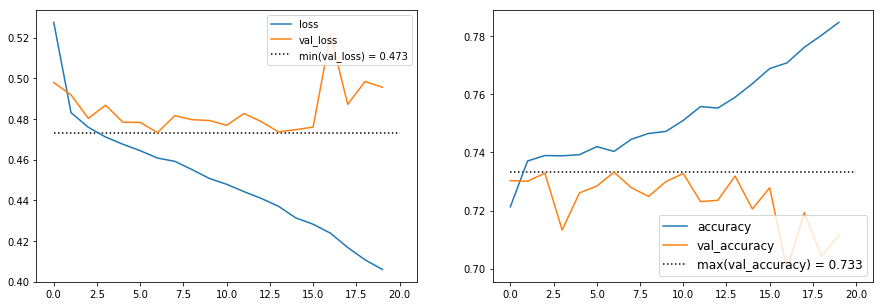

In [25]:
histplot(history)

In [25]:
prediction = []
for i in range(len(x_test_cnn)):
    img = x_test_cnn[i]
    test_image = image.img_to_array(img)
    test_image = np.expand_dims(test_image, axis=0)
    pred = cnnmodel.predict(test_image)
    prediction.append(pred)
prediction = np.array(prediction)

In [26]:
result=[]
for i in range(len(prediction)):
    if np.round(prediction[i]).item(0)==1:
        result.append(0)
    elif np.round(prediction[i]).item(1)==1:
        result.append(1)
    else:
        result.append(2)
result = np.array(result)

result_translate = ['Compt', 'Phot', 'Noise']
result_names = []
for i in range(len(result)):
    result_names.append(result_translate[result[i]])
result_names = np.array(result_names)

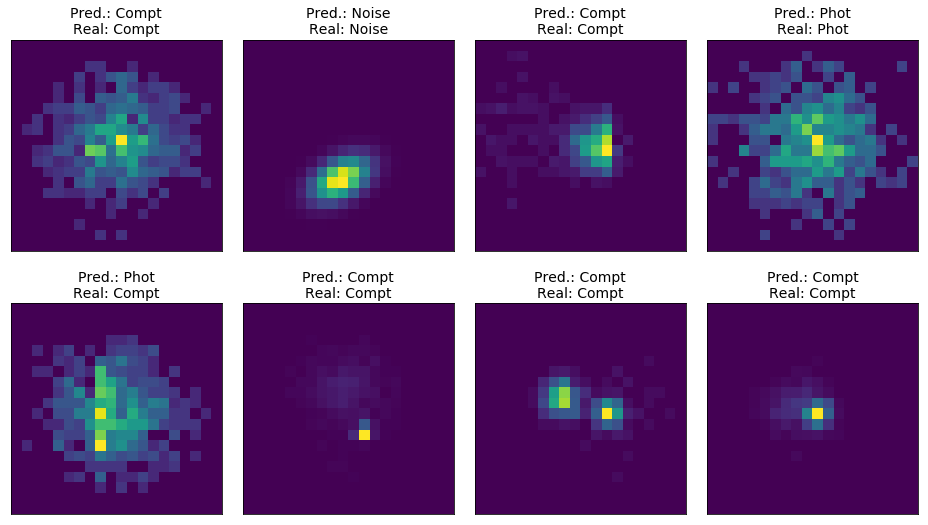

In [27]:
x_test_image = x_test.reshape(len(x_test),20,20)
fig = plt.figure(figsize=(14, 13))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(x_test_image[i], interpolation='nearest')
    
    # label the image with the target value
    ax.set_title(F'Pred.: {result_names[i]}'+ '\n' F'Real: {result_translate[int(y_test[i])]}', fontsize=14)
plt.tick_params()

In [28]:
true_results = np.equal(y_test, result)
percentage   = np.round(sum(true_results)/len(y_test)*100, decimals=2)
print('------------------------------')
print('# CORRECT PREDICTIONS:')
print(f'{sum(true_results)} of total {len(y_test)} ---> {percentage} %')
print('------------------------------')

------------------------------
# CORRECT PREDICTIONS:
4741 of total 6000 ---> 79.02 %
------------------------------


In [30]:
tot_true_phot  = np.sum(y_test==1)/100
tot_true_compt = np.sum(y_test==0)/100
tot_true_noise = np.sum(y_test==2)/100
print('True phot  labeled as  phot --->  ' , int(np.round(np.sum(result[y_test==1]==1)/tot_true_phot)), '%')
print('True phot  labeled as compt --->   ', int(np.round(np.sum(result[y_test==1]==0)/tot_true_phot)), '%')
print('True phot  labeled as noise --->   ', int(np.round(np.sum(result[y_test==1]==2)/tot_true_phot)), '%')
print('True compt labeled as compt --->  ' , int(np.round(np.sum(result[y_test==0]==0)/tot_true_compt)), '%')
print('True compt labeled as  phot --->  ' , int(np.round(np.sum(result[y_test==0]==1)/tot_true_compt)), '%')
print('True compt labeled as noise --->   ', int(np.round(np.sum(result[y_test==0]==2)/tot_true_compt)), '%')
print('True noise labeled as noise ---> '  , int(np.round(np.sum(result[y_test==2]==2)/tot_true_noise)), '%')
print('True noise labeled as  phot --->   ', int(np.round(np.sum(result[y_test==2]==1)/tot_true_noise)), '%')
print('True noise labeled as compt --->   ', int(np.round(np.sum(result[y_test==2]==0)/tot_true_noise)), '%')

True phot  labeled as  phot --->   92 %
True phot  labeled as compt --->    8 %
True phot  labeled as noise --->    0 %
True compt labeled as compt --->   59 %
True compt labeled as  phot --->   41 %
True compt labeled as noise --->    0 %
True noise labeled as noise --->  100 %
True noise labeled as  phot --->    0 %
True noise labeled as compt --->    0 %
